# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
# ! pip install -U scikit-learn<0.24

In [1]:
# !pip install pycrf
# !pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

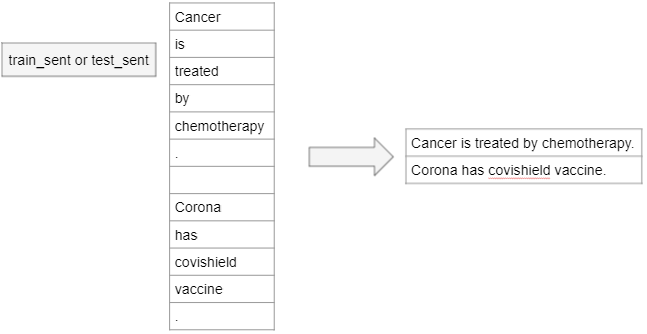

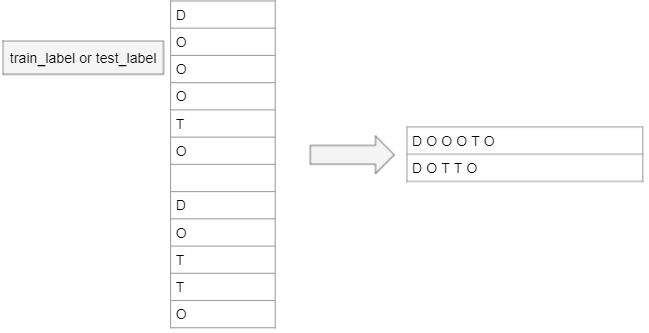

In [2]:
def words_to_sentences(words):
    '''Input: Data set containing individual words in separate lines
       Output: List containing sentences that are split by empty lines in given data'''
    
    # Split sentences by blank lines
    words = words.split("\n\n")
    out = []
    for sent in words:
        out.append([item.strip() for item in sent.split('\n')]) ## Create a list of lists containing words of sentences
    return [" ".join(i) for i in out]   # convert list of words to sentences

In [3]:
## Read the four given train and test files and convert them into sentences by splitting by empty lines
with open('data/train_sent', 'r') as train_sent_file:
    train_sent = train_sent_file.read()
train_sent = words_to_sentences(train_sent)    
    
with open('data/test_sent', 'r') as test_sent_file:
    test_sent = test_sent_file.read()
test_sent = words_to_sentences(test_sent) 
    
with open('data/train_label', 'r') as train_label_file:
    train_label = train_label_file.read()
train_label = words_to_sentences(train_label)    
    
with open('data/test_label', 'r') as test_label_file:
    test_label = test_label_file.read()
test_label = words_to_sentences(test_label)

In [4]:
# Print 5 sentences
train_sent[:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [5]:
import pandas as pd

train_df = pd.DataFrame(columns=['Sentences', 'Labels'])   # Create empty dataframe
for i in range(len(train_sent)):
    train_df.loc[len(train_df)] = [train_sent[i], train_label[i]]   # Add two columns to dataframe, for setences and labels
train_df.sample(5)  # View five random train sentences and their labels

,Sentences,Labels
1293,"A kinder , gentler approach",O O O O O
549,The odds ratios for retinopathy in subjects wi...,O O O O D O O O O O O O O O O O O O O O O O O O
2333,METHODS : Thirty-seven children with a history...,O O O O O O O O D O O O O O O O O O O O O O O ...
2492,Is concomitant radiotherapy and chemotherapy s...,O T T T T O O O T O O D D O
2482,Thalidomide for aphthous ulcers in HIV infection,T O D D O D D


In [6]:
test_df = pd.DataFrame(columns=['Sentences', 'Labels'])  # Create empty dataframe
for i in range(len(test_sent)):
    test_df.loc[len(test_df)] = [test_sent[i], test_label[i]]  # Add two columns to dataframe, for setences and labels
test_df.sample(5)   # View five random test sentences and their labels

,Sentences,Labels
1027,Peripheral retinal cryotherapy for postvitrect...,T T T O D D D D O O O
1021,Intravenous immunoglobulin treatment in multip...,T T T O D D
586,Arthrodesis of the first metatarsophalangeal j...,T T T T T T O O D D D D
960,High-dose intravenous immunoglobulin ( hdIVIg ...,T T T T T T O O O O O O O O D D D D
1,"As the ambient temperature increases , there i...",O O O O O O O O O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset 

In [7]:
## View the number of sentences in train and test data sets

print(f"Number of sentences in train_sent = {len(train_sent)}")
print(f"Number of sentences in test_sent = {len(test_sent)}")

Number of sentences in train_sent = 2600
Number of sentences in test_sent = 1057


### Count the number of lines of labels in the processed train and test dataset.

In [8]:
## View the number of lines of labels in train and test data sets

print(f"Number of lines of labels in train_label = {len(train_label)}")
print(f"Number of lines of labels in test_label = {len(test_label)}")

Number of lines of labels in train_label = 2600
Number of lines of labels in test_label = 1057


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [10]:
## Extract tokens having PoS tag 'NOUN' or 'PROPN' from both training and test sentences and save them in one list 'nouns'
nouns = []

for sent in train_sent:
    doc = nlp(sent)
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())

for sent in test_sent:
    doc = nlp(sent)
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())
nouns   # View the list

['birth',
 '=',
 'week',
 'university',
 'vermont',
 '=',
 'delivery',
 'route',
 'indication',
 'cesarean',
 'age',
 'parity',
 'practice',
 'group',
 'risk',
 'status',
 'rate',
 '%',
 'rate',
 '%',
 'presentation',
 'indication',
 '%',
 'rate',
 'medicine',
 'patient',
 '%',
 'rate',
 '%',
 'arrest',
 'dilation',
 'indication',
 'subgroup',
 '%',
 'rate',
 'care',
 'hospital',
 'rate',
 'community',
 'hospital',
 'group',
 'age',
 'trimester',
 'index',
 'afi',
 'fluid',
 'status',
 'temperature',
 'increase',
 'decrease',
 'afi',
 'june',
 'august',
 'period',
 'heat',
 'woman',
 'singleton',
 'pregnancy',
 'week',
 'gestation',
 'antenatal',
 'testing',
 'determination',
 'temperature',
 'area',
 '2-',
 'day',
 'temperature',
 'test',
 'date',
 'afi',
 'spearman',
 'rank',
 'correlation',
 'relationship',
 'account',
 'afi',
 'measure',
 'study',
 'population',
 'woman',
 'diabetes',
 'screening',
 'woman',
 'clinic',
 'hadassah',
 'medical',
 'center',
 'year',
 'period',
 'woman

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [11]:
## Convert the list of nouns to a pandas series to obtain frequencies of each noun using value_counts() method
noun_series = pd.Series(nouns).value_counts()
noun_series

patient           568
treatment         316
%                 247
study             235
cancer            226
                 ... 
myth                1
agalactiae          1
alcoholism          1
antiretroviral      1
obesity             1
Length: 5158, dtype: int64

In [12]:
## Create a dictionary of counts/frequencies
count_dict = {}
for noun in nouns:
    count_dict[noun] = noun_series.loc[noun]
count_dict

{'birth': 10,
 '=': 16,
 'week': 48,
 'university': 8,
 'vermont': 1,
 'delivery': 24,
 'route': 3,
 'indication': 6,
 'cesarean': 4,
 'age': 61,
 'parity': 4,
 'practice': 45,
 'group': 145,
 'risk': 78,
 'status': 17,
 'rate': 103,
 '%': 247,
 'presentation': 9,
 'medicine': 43,
 'patient': 568,
 'arrest': 6,
 'dilation': 4,
 'subgroup': 6,
 'care': 57,
 'hospital': 37,
 'community': 16,
 'trimester': 4,
 'index': 16,
 'afi': 7,
 'fluid': 7,
 'temperature': 11,
 'increase': 31,
 'decrease': 6,
 'june': 2,
 'august': 6,
 'period': 30,
 'heat': 5,
 'woman': 89,
 'singleton': 1,
 'pregnancy': 46,
 'gestation': 9,
 'antenatal': 5,
 'testing': 25,
 'determination': 8,
 'area': 17,
 '2-': 3,
 'day': 63,
 'test': 35,
 'date': 3,
 'spearman': 1,
 'rank': 2,
 'correlation': 20,
 'relationship': 18,
 'account': 4,
 'measure': 8,
 'study': 235,
 'population': 37,
 'diabetes': 33,
 'screening': 14,
 'clinic': 12,
 'hadassah': 1,
 'medical': 6,
 'center': 12,
 'year': 105,
 'treatment': 316,
 'pr

In [13]:
## Use pandas 'head()' method to obtain the top 25 most common tokens in given data
print(f"-----------------------------------------------------")
print(f"Top 25 Most Common Tokens with NOUN or PROPN PoS Tags")
print(f"-----------------------------------------------------")
noun_series.head(25)   

-----------------------------------------------------
Top 25 Most Common Tokens with NOUN or PROPN PoS Tags
-----------------------------------------------------


patient         568
treatment       316
%               247
study           235
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            131
result          121
lung            120
gene            111
year            105
rate            103
chemotherapy     91
use              91
trial            90
conclusion       89
woman            89
analysis         86
dose             83
protein          82
response         81
dtype: int64

## Defining features for CRF





In [14]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(words_of_sentence, i, token_PoS_list):
    '''
    Parameters:
    'words_of_sentences': list of all words in a sentence
    'i' : position of the word in the above list 'words_of_sentences'
    'token_PoS_list': list of PoS tags of corresponding words in above list 'words_of_sentences'
    
    Returns:
    'features': a list of all the features of the word at ith position in the list 'words_of_sentences'
    
    '''
    word = words_of_sentence[i]

    features = [
        'word.PoS=' + token_PoS_list[i], # PoS tag of the word
        'word.lower=' + word.lower(),    # word in lower case
        'word[-3:]=' + word[-3:],        # last three characters
        'word[-2:]=' + word[-2:],        # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        #'word.isalnum=%s' % word.isalnum(),  # is the word a number

        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
      ]
        
    if(i > 0):
            prev_word = words_of_sentence[i-1]
            features.extend([
                'prev_word.PoS=' + token_PoS_list[i-1], # PoS tag of the previous word
                'prev_word.lower=' + prev_word.lower(), # previous word in lower case
                'prev_word[-3:]=' + prev_word[-3:],        # last three characters of previous word
                'prev_word[-2:]=' + prev_word[-2:],        # last two characters of previous word
                'prev_word.isupper=%s' % prev_word.isupper(), # is the previous word in all uppercase
                'prev_word.isdigit=%s' % prev_word.isdigit(), # is the previous word a number
                #'prev_word.isalnum=%s' % prev_word.isalnum(), # is the previous word a number
                'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is the previous word starting with a capital letter
      ])
        
    else:
            features.append('BEG') # feature to track begin of sentence 
        
        
    if(i == len(words_of_sentence)-1):
            features.append('END') # feature to track end of sentence
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [15]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    doc = nlp(sentence)
    token_PoS_list = [tok.pos_ for tok in doc]
    words_of_sentence = sentence.split()
    return [getFeaturesForOneWord(words_of_sentence, i, token_PoS_list) for i in range(len(words_of_sentence))]

### Write a code/function to get the labels of a sentence

In [16]:
# Write a code to get labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [17]:
## Extract features from training and test data
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [18]:
## Extract labels from training and test data
y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [19]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=1)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|█████████████████████████████████████████| 2600/2600 [00:00<00:00, 5945.25it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 26691
Seconds required: 0.102

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.03  loss=23261.96 active=26145 feature_norm=1.00
Iter 2   time=0.02  loss=22157.63 active=25293 feature_norm=0.89
Iter 3   time=0.02  loss=21236.93 active=25015 feature_norm=0.70
Iter 4   time=0.02  loss=20484.64 active=26455 feature_norm=0.79
Iter 5   time=0.02  loss=19077.36 active=26391 feature_norm=1.05
Iter 6   time=0.02  loss=16898.67 active=26539 feature_norm=1.36
Iter 7   time=0.02  loss=13881.19 active=26443 feature_norm=3.47
Iter 8   time=0.02  loss=13296.51 active=26514 feature_norm=3.55
Iter 9   time=0.02  loss=12624.31 active=26523 feature_norm=3.62
Iter 10  time=

d:\masters_aiml\aiml\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=1)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [20]:
# Make predictions on test data
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [21]:
# View the f1 score of our model
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9215795034234411

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

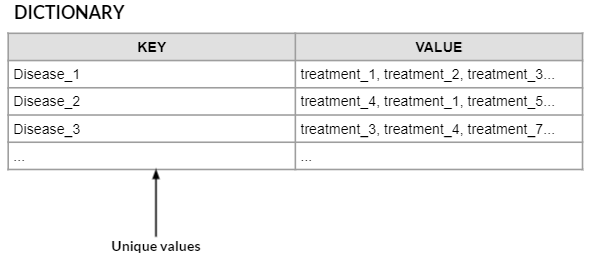

In [22]:
## First we extract indices of labels having values 'D' & 'T' in y_pred
indices_D = []
indices_T = []

for row in y_pred:
    indices_D.append([i for i, x in enumerate(row) if x == 'D'])
    indices_T.append([i for i, x in enumerate(row) if x == 'T'])

# View the list of indices
print(indices_D)
print('\n------------------------------------------------------\n')
print(indices_T)

[[], [], [], [], [], [11, 12, 13, 14, 15, 16], [], [], [], [], [], [], [10, 16, 17, 18], [12], [], [3, 4], [], [], [], [], [6, 7, 8], [0, 1, 2, 3, 20, 21, 22, 23], [], [], [], [], [], [16], [], [37, 38, 43, 44, 50, 51], [], [], [], [6, 7], [11, 12], [], [10, 11, 12], [19, 20], [], [14, 15, 16, 17, 18], [], [], [], [], [], [], [13, 17, 18], [], [], [], [], [], [], [10, 11], [], [13], [], [], [], [], [], [9, 11], [], [], [], [], [], [], [], [], [], [27, 28, 29, 30, 31, 32], [], [18, 19], [], [9, 10, 11], [], [], [], [], [], [], [], [], [], [], [], [], [6, 7], [], [], [], [], [], [], [], [], [], [], [], [33, 34, 35], [], [], [30, 31], [], [12, 13, 14, 15], [], [], [], [4, 5], [], [34], [], [], [], [20, 21, 22, 23, 24, 25, 26, 27], [], [], [], [29, 30], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [6, 7], [], [], [44], [], [11, 12], [], [5, 8, 9], [], [8, 9], [20, 21], [], [6, 7], [], [], [11, 12], [], [], 

In [28]:
## Now we will use above indices_D to slice our test sentences to get names of Diseases

diseases = []
for i in range(len(indices_D)):
    lis_D = []
    for j in indices_D[i]:
        lis_D.append(test_sent[i].split()[j])
    diseases.append(lis_D)
diseases

[[],
 [],
 [],
 [],
 [],
 ['macrosomic', 'infants', 'in', 'gestational', 'diabetes', 'cases'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['microcephaly', 'nonimmune', 'hydrops', 'fetalis'],
 ['preeclampsia'],
 [],
 ['severe', 'preeclampsia'],
 [],
 [],
 [],
 [],
 ['asymmetric', 'double', 'hemiplegia'],
 ['A',
  'subchorial',
  'placental',
  'hematoma',
  'reversible',
  'nonimmune',
  'hydrops',
  'fetalis'],
 [],
 [],
 [],
 [],
 [],
 ['cancer'],
 [],
 ['breast', 'cancer', 'breast', 'cancer', 'ovarian', 'cancer'],
 [],
 [],
 [],
 ['prostate', 'cancer'],
 ['prostate', 'cancers'],
 [],
 ['hereditary', 'prostate', 'cancer'],
 ['prostate', 'cancer'],
 [],
 ['multiple', 'sclerosis', '(', 'MS', ')'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['cancer', 'hereditary', 'retinoblastoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['pericardial', 'effusions'],
 [],
 ['deafness'],
 [],
 [],
 [],
 [],
 [],
 ['epilepsy', 'ADHD'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial',

In [29]:
## Next we will use above indices_T to slice our test sentences to get names of Treatments

treatments = []
for i in range(len(indices_T)):
    lis_T = []
    for k in indices_T[i]:
        lis_T.append(test_sent[i].split()[k])
    treatments.append(lis_T)
treatments

[[],
 [],
 [],
 [],
 [],
 ['good', 'glycemic', 'control'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Trisomy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['radiotherapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hearing', 'aids'],
 [],
 [],
 [],
 ['methylphenidate'],
 [],
 ['Methylphenidate'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['aspirin',
  ',',
  '3',
  'mg',
  'warfarin',
  'aspirin',
  ',',
  'or',
  '1',
  'mg',
  'warfarin',
  'aspirin'],
 ['warfarin', 'aspirin'],
 [],
 ['roxithromycin'],
 [],
 ['Antichlamydial', 'antibiotics'],
 ['surgery', 'radical', 'radiotherapy'],
 [],
 [],
 [],
 [],
 ['beta', 'human', 'chorionic', 'gondotropin'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['electrical', 'nerve', 'stimulation', '(', 'ENS', ')', 'therapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['surg

In [25]:
## Create a dataframe containing Diseases and Treatments of each sentence in test data
final = pd.DataFrame({'Diseases': diseases, 'Treatments':treatments})
final

,Diseases,Treatments
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]
...,...,...
1052,[],[]
1053,"[epithelial, ovarian, cancer]","[High-dose, chemotherapy]"
1054,"[responsive, multiple, myeloma]",[]
1055,[],"[Intravenous, immune, globulin]"


In [26]:
## The rows which contain one or both columns as empty list are of no use to us, so we remove them
final = final[(final['Diseases'].map(lambda d: len(d)) > 0)]
final = final[(final['Treatments'].map(lambda d: len(d)) > 0)]
final

,Diseases,Treatments
5,"[macrosomic, infants, in, gestational, diabete...","[good, glycemic, control]"
12,"[microcephaly, nonimmune, hydrops, fetalis]",[Trisomy]
46,"[cancer, hereditary, retinoblastoma]",[radiotherapy]
55,[deafness],"[hearing, aids]"
61,"[epilepsy, ADHD]",[Methylphenidate]
...,...,...
1042,"[hepatic, metastases, from, colorectal, cancer]","[Hepatic, arterial, infusion, of, chemotherapy..."
1046,"[stable, asthma]","[aerosolized, salbutamol]"
1048,[Poliomyelitis],"[live, oral, poliovirus, vaccines]"
1050,"[chronic, renal, failure]",[Epoetin]


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [30]:
## We look for words of given disease in 'Diseases' column and find the correspondings treatment
print("[Disease]  - [Treatment]")
for row1, row2 in list(zip(final['Diseases'],final['Treatments'])):
    if ('hereditary' in row1 and 'retinoblastoma' in row1):
        print(row1, '-', row2)

[Disease]  - [Treatment]
['cancer', 'hereditary', 'retinoblastoma'] - ['radiotherapy']
